In [18]:
import numpy as np
import math
import random
import warnings
from scipy.integrate import quad
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt

# hpp and nhpp

In [2]:
# Homogeneous Poisson Process (hpp) inter-event time sampler
def hpp(intentemp):
    total_intensity = sum(intentemp)
    # Avoid division by zero (should be handled by caller)
    return - (1 / total_intensity) * math.log(1 - random.random())

# Nonhomogeneous Poisson Process (nhpp) inter-event time sampler using inverse transform
def nhpp(tottime, N, param, inten, timeleft):
    Y = random.random()
    def f(X):
        # Integrate sum of intensities from 0 to X
        integral, _ = quad(lambda x: sum(inten(tottime + x, N, param)), 0, X, limit=200)
        return 1 - math.exp(-integral) - Y
    try:
        sol = root_scalar(f, bracket=[0, timeleft], method='bisect', xtol=1e-5)
        return sol.root
    except ValueError:
        # In case no root is found, return a value greater than timeleft
        return timeleft + 1

# gillespie

In [14]:
# Gillespie simulation (SSA with a fixed time grid) using homogeneous sampling
def gillespie(init, times, param, inten, pproc, hpp_func):
    if len(times) == 0:
        raise ValueError("No time points provided in 'times'")
    if times[0] != 0:
        raise ValueError("First time point is not 0")

    tottime = times[0]
    tinc = len(times)
    N = np.array(init, dtype=float)  # current state (assumed 1D)
    # Prepare a results array; each row will store the state at the corresponding grid time.
    results = np.zeros((tinc, len(N)))
    results[0, :] = N.copy()

    i = 1
    while i < tinc:
        results[i, :] = results[i - 1, :].copy()
        # Process events until the simulation time exceeds the grid time points[i]
        while tottime <= times[i]:
            intentemp = inten(tottime, N, param)
            if all(x == 0 for x in intentemp):
                for j in range(i, tinc):
                    results[j, :] = N.copy()
                warnings.warn("Exiting with all intensities equal to 0")
                i = tinc  # exit outer loop
                break
            elif min(intentemp) < 0:
                for j in range(i, tinc):
                    results[j, :] = np.nan
                warnings.warn("Exiting with intensity less than 0")
                i = tinc  # exit outer loop
                break
            else:
                tau = hpp_func(intentemp)
                tottime += tau
                # Choose an event type based on the probabilities proportional to intensities.
                probabilities = np.array(intentemp) / sum(intentemp)
                event_index = np.random.choice(np.arange(pproc.shape[0]), p=probabilities.flatten())
                # If the new time is beyond the grid time, record current state and apply the event once.
                if tottime > times[i]:
                    results[i, :] = N.copy()
                    N = N + pproc[event_index, :]
                    break
                else:
                    N = N + pproc[event_index, :]
        i += 1

    # Combine the time vector and results into one array (first column is time)
    return np.column_stack((times, results))

# gillespie+

In [16]:
# Gillespie+ simulation using nonhomogeneous Poisson process sampling
def gillespie_plus(init, times, param, inten, pproc, nhpp_func):
    if len(times) == 0:
        raise ValueError("No time points provided in 'times'")
    if times[0] != 0:
        raise ValueError("First time point is not 0")
    
    tottime = times[0]
    tinc = len(times)
    N = np.array(init, dtype=float)
    results = np.zeros((tinc, len(N)))
    results[0, :] = N.copy()

    i = 1
    while i < tinc:
        results[i, :] = results[i - 1, :].copy()
        while tottime <= times[i]:
            intentemp = inten(tottime, N, param)
            if all(x == 0 for x in intentemp):
                for j in range(i, tinc):
                    results[j, :] = N.copy()
                warnings.warn("Exiting with all intensities equal to 0")
                i = tinc
                break
            elif min(intentemp) < 0:
                for j in range(i, tinc):
                    results[j, :] = np.nan
                warnings.warn("Exiting with intensity less than 0")
                i = tinc
                break
            else:
                # Use the nonhomogeneous inter-event sampler with the remaining time interval
                tau = nhpp_func(tottime, N, param, inten, times[-1] - tottime)
                tottime += tau
                # Recalculate intensities for the new time.
                intentemp = inten(tottime, N, param)
                probabilities = np.array(intentemp) / sum(intentemp)

                event_index = np.random.choice(np.arange(pproc.shape[0]), p=probabilities.flatten())
                if tottime > times[i]:
                    results[i, :] = N.copy()
                    N = N + pproc[event_index, :]
                    break
                else:
                    N = N + pproc[event_index, :]
        i += 1

    return np.column_stack((times, results))

# test models

In [26]:
# Initial population size
init = [100]  # using a list for one-dimensional state

# Time grid: from 0 to 20 in steps of 1
times = np.arange(0, 101, 1)

# Environment function: fluctuating environment
def fluctuating2(x):
    return (math.sin(x * 2) + 1) / 1.5

# Demographic functions for birth and death
def births(b, env_res):
    return b * env_res

def deaths(d, env_res):
    return d

# Combine parameters into a dictionary.
param = {
    'b': 0.03,
    'd': 0.027,
    'env': fluctuating2,
    'births': births,
    'deaths': deaths
}

# Intensity function using demographic functions and environment.
def inten(t, X, param):
    env_val = param['env'](t)
    b_int = X * param['births'](param['b'], env_val)
    d_int = X * param['deaths'](param['d'], env_val)
    # Return two intensities: one for birth and one for death.
    return [b_int, d_int]

# State change matrix due to events: birth increases population by 1, death decreases by 1.
pproc = np.array([[1],   # birth: add 1
                  [-1]]) # death: subtract 1

# Set a random seed for reproducibility
np.random.seed(20170915)
random.seed(20170915)

# Run simulation using gillespie (homogeneous Poisson process sampler)
res_gillespie = gillespie(init, times, param, inten, pproc, hpp)
print("Results from gillespie:")
print(res_gillespie)

# Reset the seed for reproducibility before running the second simulation
np.random.seed(20170915)
random.seed(20170915)

# Run simulation using gillespie_plus (nonhomogeneous Poisson process sampler)
res_gillespie_plus = gillespie_plus(init, times, param, inten, pproc, nhpp)
print("\nResults from gillespie_plus:")
print(res_gillespie_plus)

/var/folders/nf/336h2vrj3gx4f2_bc7f8p98h0000gn/T/ipykernel_16514/2052021736.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return (math.sin(x * 2) + 1) / 1.5


Results from gillespie:
[[  0. 100.]
 [  1. 102.]
 [  2. 103.]
 [  3. 102.]
 [  4. 102.]
 [  5. 103.]
 [  6. 100.]
 [  7.  96.]
 [  8. 100.]
 [  9.  99.]
 [ 10.  98.]
 [ 11.  98.]
 [ 12.  96.]
 [ 13.  93.]
 [ 14.  95.]
 [ 15.  98.]
 [ 16.  96.]
 [ 17.  96.]
 [ 18.  95.]
 [ 19.  92.]
 [ 20.  90.]
 [ 21.  90.]
 [ 22.  89.]
 [ 23.  93.]
 [ 24.  97.]
 [ 25.  96.]
 [ 26.  93.]
 [ 27.  94.]
 [ 28.  93.]
 [ 29.  92.]
 [ 30.  96.]
 [ 31.  89.]
 [ 32.  91.]
 [ 33.  93.]
 [ 34.  90.]
 [ 35.  88.]
 [ 36.  96.]
 [ 37.  93.]
 [ 38.  92.]
 [ 39.  90.]
 [ 40.  89.]
 [ 41.  87.]
 [ 42.  91.]
 [ 43.  93.]
 [ 44.  89.]
 [ 45.  88.]
 [ 46.  89.]
 [ 47.  88.]
 [ 48.  86.]
 [ 49.  85.]
 [ 50.  84.]
 [ 51.  81.]
 [ 52.  80.]
 [ 53.  79.]
 [ 54.  79.]
 [ 55.  79.]
 [ 56.  78.]
 [ 57.  79.]
 [ 58.  78.]
 [ 59.  81.]
 [ 60.  79.]
 [ 61.  80.]
 [ 62.  80.]
 [ 63.  74.]
 [ 64.  73.]
 [ 65.  73.]
 [ 66.  72.]
 [ 67.  74.]
 [ 68.  75.]
 [ 69.  75.]
 [ 70.  75.]
 [ 71.  75.]
 [ 72.  74.]
 [ 73.  72.]
 [ 74.  72.]
 

In [28]:
fluctuating2(0.5)

1.2276473232052643

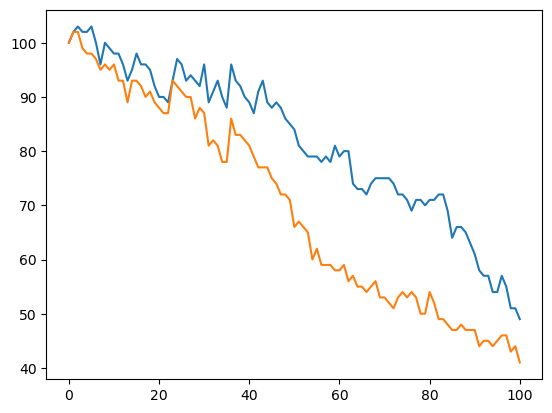

In [27]:
plt.plot(times, res_gillespie[:,1])
plt.plot(times, res_gillespie_plus[:,1])